# Install fed_rf_mk package

Package available at: https://pypi.org/project/fed-rf-mk/

Uncomment the following line to install the package

The usage of a virtual environment is recommended. ``python -m venv venv`` then ``source venv/bin/activate``


In [1]:
#!pip install -r requirements.txt

In [2]:
#!pip install fed-rf-mk

# Data Treatment

In [3]:
import random
import os
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.utils import resample

Import the aids clinical trial dataset from ucirepo.

In [4]:

# Fetch dataset
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# Extract data
X = aids_clinical_trials_group_study_175.data.features  # Features DataFrame
y = aids_clinical_trials_group_study_175.data.targets  # Target DataFrame

# Debug: Print available column names
print("Features (X) columns:", X.columns.tolist())
print("Target (y) columns:", y.columns.tolist())

# Ensure 'cid' is in y
if "cid" not in y.columns:
    print("Error: 'cid' column is missing from the target DataFrame!")
    print("Available target columns:", y.columns.tolist())
    exit()

# Combine X and y into a single DataFrame
df = pd.concat([X, y], axis=1)
all_features = [col for col in df.columns if col != 'cid']  # Exclude target

Features (X) columns: ['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'z30', 'zprior', 'preanti', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']
Target (y) columns: ['cid']


Simulate a distributed enviroment with 3 clients.

Last client is the test client and have 20% of the data.

The remaining clients have 40% of the data each which will be used for training.

In [5]:
from sklearn.utils import shuffle

# Define number of partitions
N = 3  
TRAIN_RATIO = 0.8  # 80% for training, 20% for testing


# Load dataset (Assuming df is already loaded and contains 'cid' column)
df["cid"].value_counts(normalize=True) * 100

# Separate classes
df_majority = df[df["cid"] == 0]  # cid = 0 (majority)
df_minority = df[df["cid"] == 1]  # cid = 1 (minority)

print("Majority class (cid=0) count:", len(df_majority))
print("Minority class (cid=1) count:", len(df_minority))

# Shuffle data for randomness
df_majority = shuffle(df_majority, random_state=42).reset_index(drop=True)
df_minority = shuffle(df_minority, random_state=42).reset_index(drop=True)

# Split data into 80% training and 20% testing
majority_train_size = int(len(df_majority) * TRAIN_RATIO)
minority_train_size = int(len(df_minority) * TRAIN_RATIO)

df_majority_train = df_majority.iloc[:majority_train_size]
df_majority_test = df_majority.iloc[majority_train_size:]

df_minority_train = df_minority.iloc[:minority_train_size]
df_minority_test = df_minority.iloc[minority_train_size:]

# Allocate 80% training data into N-1 partitions
train_partitions = [[] for _ in range(N - 1)]

for i in range(len(df_majority_train)):
    train_partitions[i % (N - 1)].append(df_majority_train.iloc[i])

for i in range(len(df_minority_train)):
    train_partitions[i % (N - 1)].append(df_minority_train.iloc[i])

# Convert training partitions into DataFrames
train_partitions = [pd.DataFrame(part) for part in train_partitions]

# The last partition gets the 20% test data
test_partition = pd.concat([df_majority_test, df_minority_test]).sample(frac=1, random_state=42).reset_index(drop=True)


Majority class (cid=0) count: 1618
Minority class (cid=1) count: 521


In [6]:

# Create output directory
output_dir = "train_datasets/aids_clinical"
os.makedirs(output_dir, exist_ok=True)

# Save training partitions
for i, part in enumerate(train_partitions):
    file_path = os.path.join(output_dir, f"part_{i}.csv")
    part.to_csv(file_path, index=False)

    # Check file size
    size_in_bytes = os.path.getsize(file_path)
    size_in_megabytes = size_in_bytes / (1024 * 1024)

    print(f"\n📊 Distribution of 'cid' in part_{i} (Training):")
    print(part["cid"].value_counts(normalize=True) * 100)
    print(f"Space occupied by part_{i}: {size_in_bytes} bytes ({size_in_megabytes:.2f} MB)")

# Save the last partition as the test set
file_path = os.path.join(output_dir, f"part_{N-1}.csv")
test_partition.to_csv(file_path, index=False)

# Check file size
size_in_bytes = os.path.getsize(file_path)
size_in_megabytes = size_in_bytes / (1024 * 1024)

print(f"\n📊 Distribution of 'cid' in part_{N-1} (Testing):")
print(test_partition["cid"].value_counts(normalize=True) * 100)
print(f"Space occupied by part_{N-1}: {size_in_bytes} bytes ({size_in_megabytes:.2f} MB)")

print("\n✅ Partitioning with 80%-20% split completed successfully!")


📊 Distribution of 'cid' in part_0 (Training):
cid
0.0    75.672515
1.0    24.327485
Name: proportion, dtype: float64
Space occupied by part_0: 97489 bytes (0.09 MB)

📊 Distribution of 'cid' in part_1 (Training):
cid
0.0    75.672515
1.0    24.327485
Name: proportion, dtype: float64
Space occupied by part_1: 97503 bytes (0.09 MB)

📊 Distribution of 'cid' in part_2 (Testing):
cid
0    75.524476
1    24.475524
Name: proportion, dtype: float64
Space occupied by part_2: 29236 bytes (0.03 MB)

✅ Partitioning with 80%-20% split completed successfully!


# Launch Servers

Start each datasite in a different terminal.

The auto_accept function can be set to True to automatically accept requests from clients. Otherwise, each dataowner will have to accept the requests manually.

The weight of each datasite can also be set. It is usefull if the datasites have different number of samples or samples with different importance. If not set, the weight is equally distributed by all training datasites.


In [ ]:
from fed_rf_mk.server import FLServer
import threading

server = FLServer("aids_clinical_part_0", 8080, "train_datasets/aids_clinical/part_0.csv", auto_accept=False)
server_thread = threading.Thread(target=server.start, daemon=True)
server_thread.start()


Starting DataSite aids_clinical_part_0 on port 8080 with data at train_datasets/aids_clinical/part_0.csv and mock at train_datasets/aids_clinical/part_0.csv
Starting aids_clinical_part_0 server on 0.0.0.0:8080


INFO:     Starting server with settings: {'name': 'aids_clinical_part_0', 'server_type': <ServerType.DATASITE: 'datasite'>, 'server_side_type': <ServerSideType.HIGH_SIDE: 'high'>, 'deployment_type': <DeploymentType.PYTHON: 'python'>, 'processes': 1, 'reset': True, 'dev_mode': False, 'enable_warnings': False, 'in_memory_workers': True, 'queue_port': None, 'create_producer': True, 'n_consumers': 3, 'association_request_auto_approval': False, 'background_tasks': False, 'db_config': None, 'db_url': None} and worker class: <class 'syft.server.datasite.Datasite'>
CRITICAL:syft.server.server:Hash of the signing key '174ec...'


Using SQLiteDBConfig and sqlite:////tmp/syft/2febbeecb9ef480b95795a0beb2f14e6/db/2febbeecb9ef480b95795a0beb2f14e6_json.db


INFO:     Started server process [190138]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)


Waiting for server to start Done.
Logged into <aids_clinical_part_0: High side Datasite> as <info@openmined.org>


Uploading: Asset: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Datasite aids_clinical_part_0 is up and running: http://localhost:8080
Server running in manual mode. Use `.list_pending_requests()` to view requests.
DEBUG: Single output SHAP values
Space occupied by result: 178921 bytes (0.17 MB)
Number of features: 23
SHAP sample size: 100
DEBUG: Single output SHAP values
Space occupied by result: 178921 bytes (0.17 MB)
Number of features: 23
SHAP sample size: 100


In [ ]:

server2 = FLServer("aids_clinical_part_1", 8081, "train_datasets/aids_clinical/part_1.csv", auto_accept=True)
server_thread = threading.Thread(target=server2.start, daemon=True)
server_thread.start()


Starting DataSite aids_clinical_part_1 on port 8081 with data at train_datasets/aids_clinical/part_1.csv and mock at train_datasets/aids_clinical/part_1.csv
Starting aids_clinical_part_1 server on 0.0.0.0:8081


INFO:     Starting server with settings: {'name': 'aids_clinical_part_1', 'server_type': <ServerType.DATASITE: 'datasite'>, 'server_side_type': <ServerSideType.HIGH_SIDE: 'high'>, 'deployment_type': <DeploymentType.PYTHON: 'python'>, 'processes': 1, 'reset': True, 'dev_mode': False, 'enable_warnings': False, 'in_memory_workers': True, 'queue_port': None, 'create_producer': True, 'n_consumers': 3, 'association_request_auto_approval': False, 'background_tasks': False, 'db_config': None, 'db_url': None} and worker class: <class 'syft.server.datasite.Datasite'>
CRITICAL:syft.server.server:Hash of the signing key '1e7fc...'


Using SQLiteDBConfig and sqlite:////tmp/syft/75b8dbccb84d41da90c5229717429e6f/db/75b8dbccb84d41da90c5229717429e6f_json.db


INFO:     Started server process [190141]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8081 (Press CTRL+C to quit)


Waiting for server to start Done.
Logged into <aids_clinical_part_1: High side Datasite> as <info@openmined.org>





Uploading: Asset: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Datasite aids_clinical_part_1 is up and running: http://localhost:8081
Approving request on change ml_experiment for datasite aids_clinical_part_1
DEBUG: Single output SHAP values
Space occupied by result: 177312 bytes (0.17 MB)
Number of features: 23
SHAP sample size: 100
DEBUG: Single output SHAP values
Space occupied by result: 177312 bytes (0.17 MB)
Number of features: 23
SHAP sample size: 100


In [ ]:

server3 = FLServer("aids_clinical_part_2", 8082, "train_datasets/aids_clinical/part_2.csv", auto_accept=False)
server_thread = threading.Thread(target=server3.start, daemon=True)
server_thread.start()

Starting DataSite aids_clinical_part_2 on port 8082 with data at train_datasets/aids_clinical/part_2.csv and mock at train_datasets/aids_clinical/part_2.csv
Starting aids_clinical_part_2 server on 0.0.0.0:8082


INFO:     Starting server with settings: {'name': 'aids_clinical_part_2', 'server_type': <ServerType.DATASITE: 'datasite'>, 'server_side_type': <ServerSideType.HIGH_SIDE: 'high'>, 'deployment_type': <DeploymentType.PYTHON: 'python'>, 'processes': 1, 'reset': True, 'dev_mode': False, 'enable_warnings': False, 'in_memory_workers': True, 'queue_port': None, 'create_producer': True, 'n_consumers': 3, 'association_request_auto_approval': False, 'background_tasks': False, 'db_config': None, 'db_url': None} and worker class: <class 'syft.server.datasite.Datasite'>
CRITICAL:syft.server.server:Hash of the signing key '037bc...'


Using SQLiteDBConfig and sqlite:////tmp/syft/07f2b7e700ef4cf79632b20d6500eb5b/db/07f2b7e700ef4cf79632b20d6500eb5b_json.db


INFO:     Started server process [190147]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8082 (Press CTRL+C to quit)


Waiting for server to start Done.
Logged into <aids_clinical_part_2: High side Datasite> as <info@openmined.org>


Uploading: Asset: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Datasite aids_clinical_part_2 is up and running: http://localhost:8082
Server running in manual mode. Use `.list_pending_requests()` to view requests.


In [10]:
# sleep time to make sure datasites are up before proceeding

import time
time.sleep(10)

SyftInfo: You have launched a development server at http://0.0.0.0:8080. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8081. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8082. It is intended only for local use.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

## Client Notebook

With the server running, the client is initiated and connected to the datasites (2 training sites and 1 test site).


In [11]:
from fed_rf_mk.client import FLClient

rf_client = FLClient()

## COnnect to N client
for i in range(N-1):
    port = 8080 + i
    rf_client.add_train_client(name=f"aids_clinical_part_{i+1}",
                               url=f"http://localhost:{port}", email="fedlearning@rf.com", password="****")

# CONNECT EVAL CLIENT
eval_port = 8080 + N - 1
rf_client.add_eval_client(name=f"aids_clinical_part_{N}",
    url=f"http://localhost:{eval_port}", email="fedlearning@rf.com", password="****")

rf_client.add_train_client(name="aids_clinical_part_1", url="http://localhost:8080", email="fedlearning@rf.com", password="****")
rf_client.add_train_client(name="aids_clinical_part_2", url="http://localhost:8081", email="fedlearning@rf.com", password="****")
rf_client.add_eval_client(name="aids_clinical_part_3", url="http://localhost:8082", email="fedlearning@rf.com", password="****")


Logged into <aids_clinical_part_0: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_1 at http://localhost:8080
Logged into <aids_clinical_part_1: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_2 at http://localhost:8081
Logged into <aids_clinical_part_2: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_3 at http://localhost:8082
Logged into <aids_clinical_part_0: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_1 at http://localhost:8080
Logged into <aids_clinical_part_1: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_2 at http://localhost:8081
Logged into <aids_clinical_part_2: High side Datasite> as <fedlearning@rf.com>
Successfully connected to aids_clinical_part_3 at http://localhost:8082


Specification of parameters for the training process.

dataParams are the parameters involving the data treatment, such as specifying the target variable and the features to be ignored.

modelParams are the parameters for the model, such as the number of initial trees, train/test size for each epoch, and the number of epochs.


In [12]:

dataParams = {
    "target": "cid",
    "ignored_columns": ["cid"]
}

modelParams = {
    "model": None,
    "n_base_estimators": 10,
    "n_incremental_estimators": 2,
    "train_size": 0.7,
    "test_size": 0.5,
    "sample_size": None,
    "fl_epochs": 1
}

rf_client.set_data_params(dataParams)
rf_client.set_model_params(modelParams)


"Model parameters set: {'model': None, 'n_base_estimators': 10, 'n_incremental_estimators': 2, 'train_size': 0.7, 'test_size': 0.5, 'sample_size': None, 'fl_epochs': 1}"

After specifying the parameters, the request can be sent to the datasites and the status checked.

In [13]:

rf_client.send_request()

rf_client.check_status_last_code_requests()


SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'evaluate_global_model' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: aids_clinical_part_1


{ServerIdentity <name=aids_clinical_part_0, id=2febbeec, 🔑=6f85b0a5>: syft.service.code.user_code.ApprovalDecision}

Datasite: aids_clinical_part_2


{ServerIdentity <name=aids_clinical_part_1, id=75b8dbcc, 🔑=4138a06a>: syft.service.code.user_code.ApprovalDecision}

Datasite: aids_clinical_part_3


{ServerIdentity <name=aids_clinical_part_2, id=07f2b7e7, 🔑=ddc59522>: syft.service.code.user_code.ApprovalDecision}

In [14]:
server.list_pending_requests()


Pending requests:
[0] Status: {ServerIdentity <name=aids_clinical_part_0, id=2febbeec, 🔑=6f85b0a5>: syft.service.code.user_code.ApprovalDecision}


In [15]:
# server.inspect_request(0)


Since datasite 1 and 3 auto_accept was set to False, the requests will have to be accepted manually using the following command.

In [16]:
server.approve_request(0)
# server2.approve_request(0)
server3.approve_request(0)

Approving request on change ml_experiment for datasite aids_clinical_part_0
✅ Approved request at index 0.
Approving request on change evaluate_global_model for datasite aids_clinical_part_2
✅ Approved request at index 0.


After checking that all the requests have been accepted, the training can be started.
If, for some reason, a request is not accepted, the training skips that datasite and continues with the others.

In [17]:
rf_client.run_model()

All weights were None. Assigning equal weight: 0.5

Epoch 1/1
Launching first‐epoch training on all clients in parallel…
 ✔ aids_clinical_part_1 completed with shap analysis
 ✔ aids_clinical_part_2 completed with shap analysis
Re‐normalized weights among successful clients: {'aids_clinical_part_1': 0.5, 'aids_clinical_part_2': 0.5}
✔ SHAP values averaged across silos
Merging estimators from successful clients…


In [18]:
# rf_client.get_model_params()

Finally, the model can be evaluated on the test site.

In [19]:
rf_client.run_evaluate()

Number of evaluation sites: 1

Evaluating model at aids_clinical_part_3


{'mcc': 0.6583159733754791,
 'cm': array([[154,   8],
        [ 18,  35]]),
 'accuracy': 0.8790697674418605,
 'mae': 0.12093023255813953,
 'rmse': 0.3477502445119766,
 'precision': 0.8752839372633857,
 'recall': 0.8790697674418605,
 'f1_score': 0.874581650652184}

## SHAP analysis

In [20]:
rf_client.start_shap_analysis()


Generating SHAP arrays...
Generating SHAP arrays for silo: aids_clinical_part_1
Generating SHAP arrays for silo: aids_clinical_part_2
Generating averaged SHAP values...
✅ SHAP arrays generated!


In [21]:
avg_shap = rf_client.get_averaged_shap_values()

print("\n2. Understanding the structure:")
if avg_shap:
    print(f"Keys in avg_shap: {list(avg_shap.keys())}")
    print(f"Number of features: {len(avg_shap['feature_names'])}")
    print(f"Sample feature names: {avg_shap['feature_names']}")
    print(f"Sample SHAP values: {list(avg_shap['mean_abs_shap'].items())}")




2. Understanding the structure:
Keys in avg_shap: ['feature_names', 'mean_abs_shap']
Number of features: 23
Sample feature names: ['drugs', 'cd40', 'cd820', 'karnof', 'age', 'str2', 'symptom', 'offtrt', 'oprior', 'z30', 'strat', 'treat', 'homo', 'wtkg', 'hemo', 'cd80', 'gender', 'cd420', 'trt', 'zprior', 'preanti', 'time', 'race']
Sample SHAP values: [('drugs', 0.002604788547378547), ('cd40', 0.023266713136184766), ('cd820', 0.018681339476419728), ('karnof', 0.009561995582648555), ('age', 0.013898330043953418), ('str2', 0.005845908589540448), ('symptom', 0.0067574923319857275), ('offtrt', 0.014161297120791883), ('oprior', 0.003100366723148078), ('z30', 0.007056970125375851), ('strat', 0.009264969606640035), ('treat', 0.01916533574874676), ('homo', 0.005006231556484113), ('wtkg', 0.014725893345105316), ('hemo', 0.0028100258640914757), ('cd80', 0.019568789877844245), ('gender', 0.004318782155826725), ('cd420', 0.052275635546221666), ('trt', 0.010519220895424479), ('zprior', 0.0), ('prea

In [22]:
shap_df = rf_client.get_shap_feature_importance_df()
print("\n3. SHAP Feature Importance DataFrame:")
print(shap_df)


3. SHAP Feature Importance DataFrame:
    Feature  Mean_Abs_SHAP
21     time       0.158295
17    cd420       0.052276
1      cd40       0.023267
20  preanti       0.021928
15     cd80       0.019569
11    treat       0.019165
2     cd820       0.018681
13     wtkg       0.014726
7    offtrt       0.014161
4       age       0.013898
18      trt       0.010519
3    karnof       0.009562
10    strat       0.009265
9       z30       0.007057
22     race       0.006987
6   symptom       0.006757
5      str2       0.005846
12     homo       0.005006
16   gender       0.004319
8    oprior       0.003100
14     hemo       0.002810
0     drugs       0.002605
19   zprior       0.000000


In [23]:
silo1_shap, silo1_df = rf_client.get_silo_shap_values("aids_clinical_part_1")
print("\n4. SHAP values for Silo 1:")

if silo1_shap:
    print(f"Silo 1 weight: {silo1_shap['silo_weight']}")
    print(f"Silo 1 sample size: {silo1_shap['sample_size']}")
    print("Top 5 features in Silo 1:")
    print(silo1_df.head())



4. SHAP values for Silo 1:
Silo 1 weight: 0.5
Silo 1 sample size: 100
Top 5 features in Silo 1:
    Feature  Mean_Abs_SHAP
0      time       0.168850
20    cd420       0.046965
19     cd40       0.026736
22    cd820       0.023761
11  preanti       0.020657


In [24]:
silo2_shap, silo2_df = rf_client.get_silo_shap_values("aids_clinical_part_2")
print("\n5. SHAP values for Silo 2:")

if silo2_df is not None:
    print(f"Silo 2 weight: {silo2_shap['silo_weight']}")
    print(f"Silo 2 sample size: {silo2_shap['sample_size']}")
    print("Top 5 features in Silo 2:")
    print(silo2_df.head())




5. SHAP values for Silo 2:
Silo 2 weight: 0.5
Silo 2 sample size: 100
Top 5 features in Silo 2:
    Feature  Mean_Abs_SHAP
0      time       0.147741
20    cd420       0.057586
17    treat       0.033792
11  preanti       0.023198
21     cd80       0.019992


In [25]:
weighted_avg_shap = rf_client.get_weighted_average_shap_values()
if weighted_avg_shap:
    print(f"Contributing silos: {weighted_avg_shap['contributing_silos']}")
    print(f"Weights used: {weighted_avg_shap['weights_used']}")
    print(f"Total weighted samples: {weighted_avg_shap['total_samples']}")
    
    # Convert to DataFrame
    import pandas as pd
    weighted_df = pd.DataFrame(
        list(weighted_avg_shap['mean_abs_shap'].items()),
        columns=['Feature', 'Weighted_SHAP']
    ).sort_values('Weighted_SHAP', ascending=False)
    print("Top 10 features (weighted average):")
    print(weighted_df.head(23))


Contributing silos: ['aids_clinical_part_1', 'aids_clinical_part_2']
Weights used: {'aids_clinical_part_1': 0.5, 'aids_clinical_part_2': 0.5}
Total weighted samples: 100
Top 10 features (weighted average):
    Feature  Weighted_SHAP
21     time       0.158295
17    cd420       0.052276
1      cd40       0.023267
20  preanti       0.021928
15     cd80       0.019569
11    treat       0.019165
2     cd820       0.018681
13     wtkg       0.014726
7    offtrt       0.014161
4       age       0.013898
18      trt       0.010519
3    karnof       0.009562
10    strat       0.009265
9       z30       0.007057
22     race       0.006987
6   symptom       0.006757
5      str2       0.005846
12     homo       0.005006
16   gender       0.004319
8    oprior       0.003100
14     hemo       0.002810
0     drugs       0.002605
19   zprior       0.000000


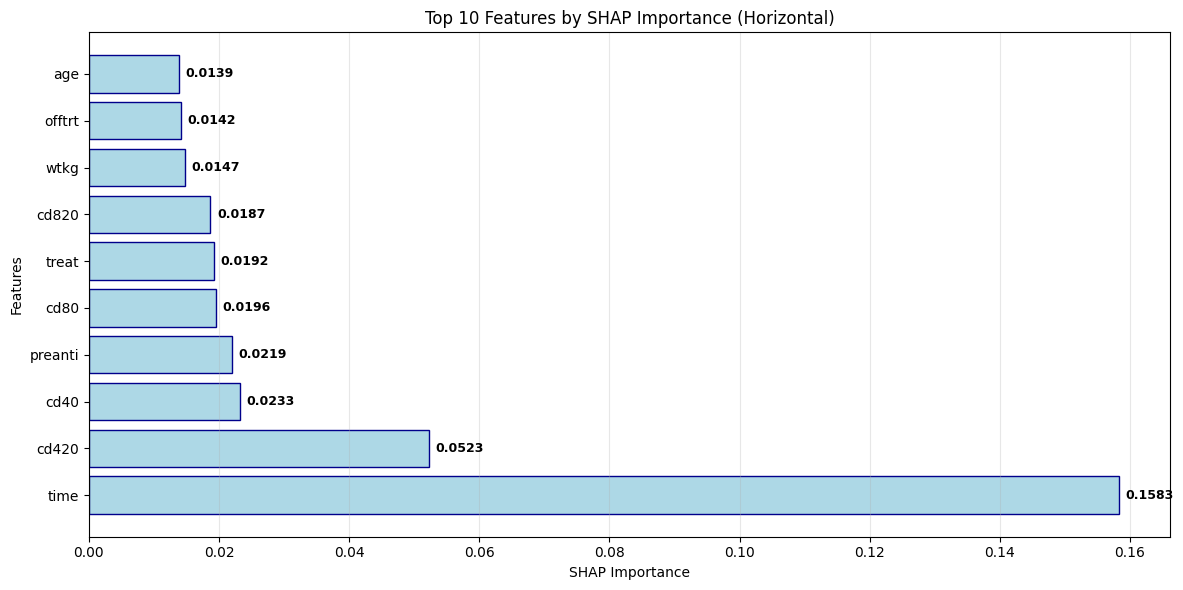

In [26]:
import matplotlib.pyplot as plt

if weighted_avg_shap:
    # Convert to DataFrame and handle potential arrays
    shap_items = []
    for feature, value in weighted_avg_shap['mean_abs_shap'].items():
        # Handle arrays by taking first element if needed
        if hasattr(value, '__getitem__') and hasattr(value, '__len__') and len(value) > 0:
            clean_value = float(value[0])
        else:
            clean_value = float(value)
        shap_items.append((feature, clean_value))
    
    weighted_df = pd.DataFrame(shap_items, columns=['Feature', 'Weighted_SHAP'])
    weighted_df = weighted_df.sort_values('Weighted_SHAP', ascending=False)
    
    # Get top 10 features
    top_features = weighted_df.head(10)
    
    # Create HORIZONTAL bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_features['Feature'], top_features['Weighted_SHAP'], 
                    color='lightblue', edgecolor='darkblue')
    
    # Add exact values in front of each bar
    for i, (feature, value) in enumerate(zip(top_features['Feature'], top_features['Weighted_SHAP'])):
        plt.text(value + 0.001, i, f'{value:.4f}', 
                va='center', ha='left', fontweight='bold', fontsize=9)
    
    plt.xlabel('SHAP Importance')
    plt.ylabel('Features')
    plt.title('Top 10 Features by SHAP Importance (Horizontal)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("No weighted SHAP data available")